<h1><center> Return Mapping Algorithm</center></h1>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
from scipy.optimize import newton
from tqdm import tqdm

### I. First Implementation of the Return Mapping Algorithm

The following implementation holds for One-Dimensional, Rate-Independent Plasticity. Combined Isotropic/Kinematic Hardening. We assume for now that the **strain follows a sqrt function wrt time**.

In [2]:
N         = 200
disc_time = np.array(range(N+1))
strain    = np.sqrt(disc_time)

In [42]:
class RMA:
    def __init__(self,strain_):
        self.strain = strain_
        self.stress = [0]
        self.epsi_p = [0]
        self.alpha  = [0]
        self.activ  = False
        
    def activate(self,E,A,b,a):
        self.activ = True
        for i in tqdm(range(len(self.strain)-1)):
            # Trial Phase
            stress_t = E * (self.strain[i+1]-self.epsi_p[i])
            epsi_p_t = self.epsi_p[i]
            alpha_t  = self.alpha[i]
            qty = (self.alpha[i]+b)**(a)
            f_t      = np.abs(stress_t) - A * qty
            if(f_t<=0):
                self.stress.append(stress_t)
                self.epsi_p.append(epsi_p_t)
                self.alpha.append(alpha_t)
            else:
                # Compute Delta_Gamma
                G=sympy.Symbol('G')
                solutions=list(sympy.solve(f_t+A*qty-E*G-A*(self.alpha[i]+b+G)**(a),G,quick=True))
                delta_G=np.max(np.array(solutions))
                s=np.sign(stress_t)
                self.stress.append(stress_t-E*delta_G*s)
                self.epsi_p.append(epsi_p_t+delta_G*s)
                self.alpha.append(alpha_t+delta_G) 
                
    def plot(self):
        plt.rcParams["figure.figsize"] = (12,5)
        plt.subplot(1,2,1)
        plt.plot(self.strain)
        plt.ylabel(r'$\epsilon$(t)',size=12)
        plt.xlabel(r'$t$',size=12)
        plt.title('Strain with respect to Time',size=13)
        plt.grid(True)     
        plt.subplot(1,2,2)
        plt.plot(self.strain,self.stress)
        plt.xlabel(r'$\epsilon$(t)',size=12)
        plt.ylabel(r'$\sigma$(t)',size=12)
        plt.title('Strain-Stress Diagram',size=13)
        plt.grid(True)
        plt.show()

In [98]:
class RMA_newton:
    def __init__(self,strain_):
        self.strain = strain_
        self.stress = [0]
        self.epsi_p = [0]
        self.alpha  = [0]
        self.activ  = False
        
    def activate(self,E,A,b,a):
        self.activ = True
        for i in tqdm(range(len(self.strain)-1)):
            # Trial Phase
            stress_t = E * (self.strain[i+1]-self.epsi_p[i])
            epsi_p_t = self.epsi_p[i]
            alpha_t  = self.alpha[i]
            qty = (self.alpha[i]+b)**(a)
            f_t      = np.abs(stress_t) - A * qty
            if(f_t<=0):
                self.stress.append(stress_t)
                self.epsi_p.append(epsi_p_t)
                self.alpha.append(alpha_t)
            else:
                # Compute Delta_Gamma
                solutions=newton(lambda G : f_t+A*qty-E*G-A*(self.alpha[i]+b+G)**(a),0,tol=0.001,maxiter=3000)
                delta_G=np.max(np.array(solutions))
                s=np.sign(stress_t)
                self.stress.append(stress_t-E*delta_G*s)
                self.epsi_p.append(epsi_p_t+delta_G*s)
                self.alpha.append(alpha_t+delta_G) 
                
    def plot(self):
        plt.rcParams["figure.figsize"] = (12,5)
        plt.subplot(1,2,1)
        plt.plot(self.strain)
        plt.ylabel(r'$\epsilon$(t)',size=12)
        plt.xlabel(r'$t$',size=12)
        plt.title('Strain with respect to Time',size=13)
        plt.grid(True)     
        plt.subplot(1,2,2)
        plt.plot(self.strain,self.stress)
        plt.xlabel(r'$\epsilon$(t)',size=12)
        plt.ylabel(r'$\sigma$(t)',size=12)
        plt.title('Strain-Stress Diagram',size=13)
        plt.grid(True)
        plt.show()

Observe the **parameters** are : 
* **E**
* **A**
* **b**
* **a** 

*Note2self: Think about feeding a dictionary of parameters and a functional based on the pseudo penalty. Goal: Achieve better generalization of the class*

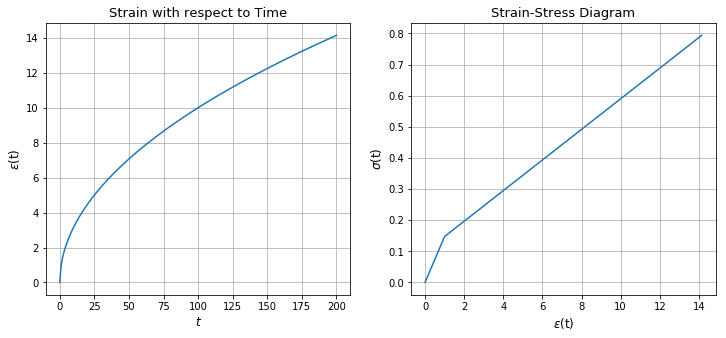

In [4]:
test=RMA(strain)
test.activate(3,0.05,2,1)
test.plot()

Erratic behavior in the stress strain Diagram. Probably due to the unusual choice choice of parameters and strain vs time function

### II. Observations for different strains

#### 1. Building different strain functions

In [5]:
N         = 300
disc_time = np.array(range(N+1))

#Linear increasing strain
slope1    = 3.5
strain1   = slope1 * disc_time
#Linear decreasing strain
slope2    = -1.5
strain2   = slope2 * disc_time
#Piecewise linear increasing/decreasing strain
stop_inc  = int(N/2)
slope3_1  = 1
slope3_2  = -0.5
estar_3   = slope3_1*disc_time[stop_inc]
bstar_3   = estar_3-slope3_2*disc_time[stop_inc]
strain3   = np.concatenate([slope3_1*disc_time[0:stop_inc],bstar_3+slope3_2*disc_time[stop_inc:]])
#Piecewise linear decreasing/increasing strain
stop_dec  = int(N/2)
slope4_1  = -0.8
slope4_2  = 1.7
estar_4   = slope4_1*disc_time[stop_inc]
bstar_4   = estar_4-slope4_2*disc_time[stop_dec]
strain4   = np.concatenate([slope4_1*disc_time[0:stop_dec],bstar_4+slope4_2*disc_time[stop_dec:]])

#### 2. RMA results

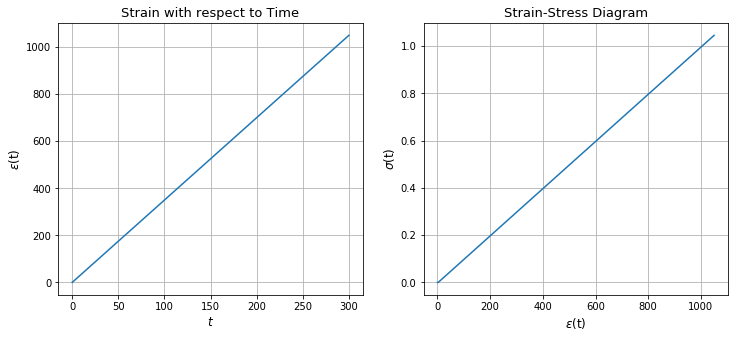

In [6]:
rma1=RMA(strain1)
rma1.activate(0.001,1,-3,0.5)
rma1.plot()

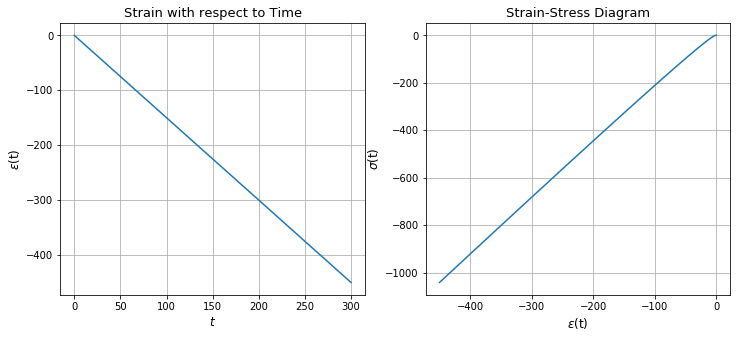

In [7]:
rma2=RMA(strain2)
rma2.activate(2.5,1,-1,2)
rma2.plot()

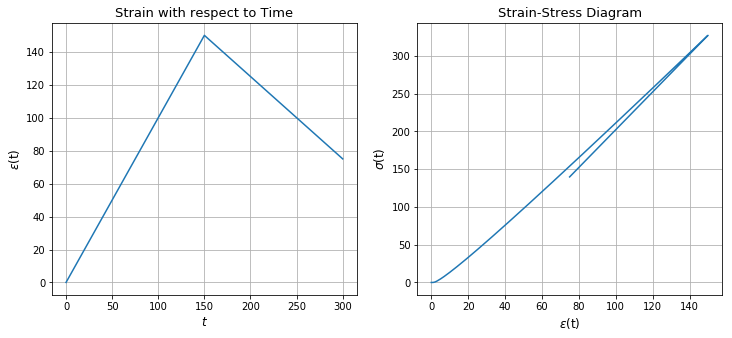

In [8]:
rma3=RMA(strain3)
rma3.activate(2.5,1,-1,2)
rma3.plot()

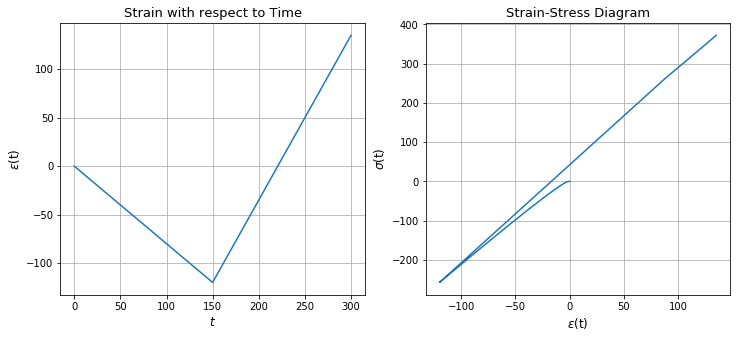

In [9]:
rma4=RMA(strain4)
rma4.activate(2.5,1,-1,2)
rma4.plot()

### III. Role of parameters : Simple Case - *Timewise linear strain*

In [10]:
N         = 1000
disc_time = np.array(range(N+1))
slope     = 0.8
strain    = slope * disc_time

#### 1. Role of Parameter E

In [11]:
rmaE_1 = RMA(strain)
rmaE_1.activate(1,1,1,1)
rmaE_2 = RMA(strain)
rmaE_2.activate(5,1,1,1)
rmaE_3 = RMA(strain)
rmaE_3.activate(10,1,1,1)

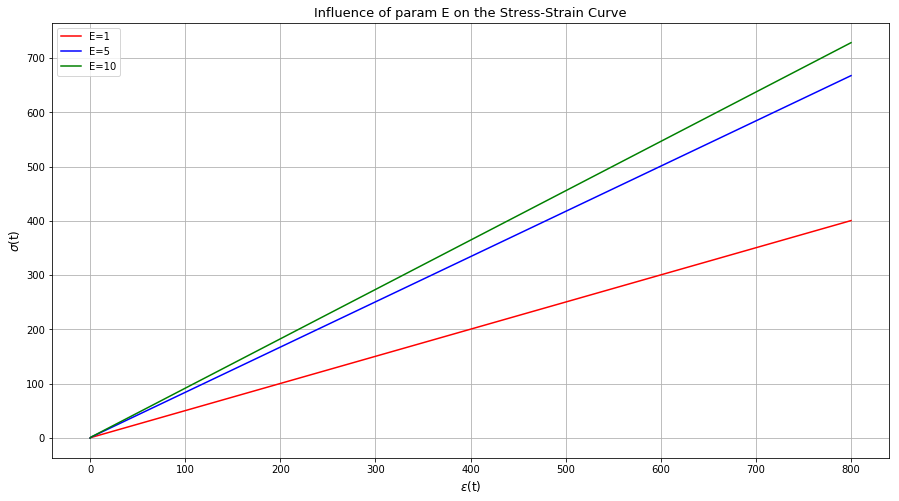

In [12]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(rmaE_1.strain,rmaE_1.stress,color='red',label='E=1')
plt.plot(rmaE_2.strain,rmaE_2.stress,color='blue',label='E=5')
plt.plot(rmaE_3.strain,rmaE_3.stress,color='green',label='E=10')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\epsilon$(t)',size=12)
plt.ylabel(r'$\sigma$(t)',size=12)
plt.title('Influence of param E on the Stress-Strain Curve',size=13)
plt.show()

#### 2. Role of Parameter A

In [13]:
# Positive A 
rmaA_1 = RMA(strain)
rmaA_1.activate(1,1,1,1)
rmaA_2 = RMA(strain)
rmaA_2.activate(1,0.1,1,1)
rmaA_3 = RMA(strain)
rmaA_3.activate(1,2,1,1)

In [14]:
# Negative A 
rmaA_4 = RMA(strain)
rmaA_4.activate(1,-0.005,1,1)

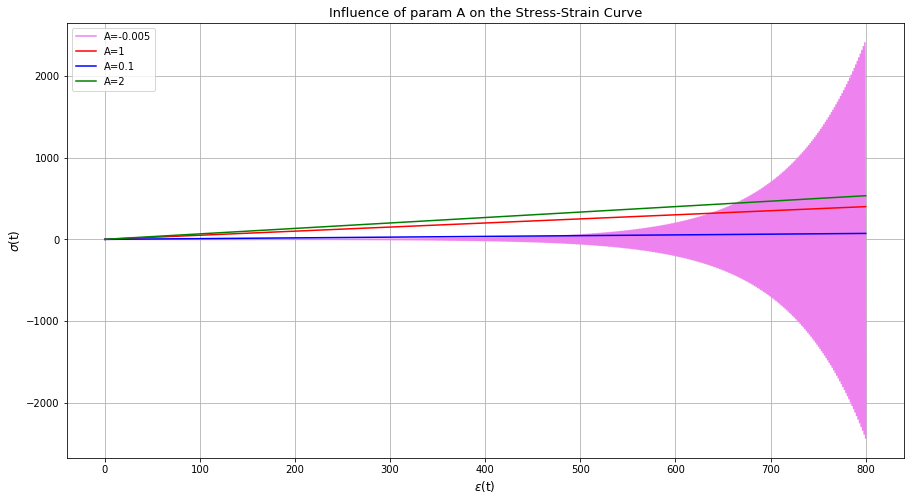

In [15]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(rmaA_4.strain,rmaA_4.stress,color='violet',label='A=-0.005')
plt.plot(rmaA_1.strain,rmaA_1.stress,color='red',label='A=1')
plt.plot(rmaA_2.strain,rmaA_2.stress,color='blue',label='A=0.1')
plt.plot(rmaA_3.strain,rmaA_3.stress,color='green',label='A=2')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\epsilon$(t)',size=12)
plt.ylabel(r'$\sigma$(t)',size=12)
plt.title('Influence of param A on the Stress-Strain Curve',size=13)
plt.show()

#### 3. Role of Parameter b

In [16]:
rmab_1 = RMA(strain)
rmab_1.activate(1,1,-10,1)
rmab_2 = RMA(strain)
rmab_2.activate(1,1,0,1)
rmab_3 = RMA(strain)
rmab_3.activate(1,1,30,1)

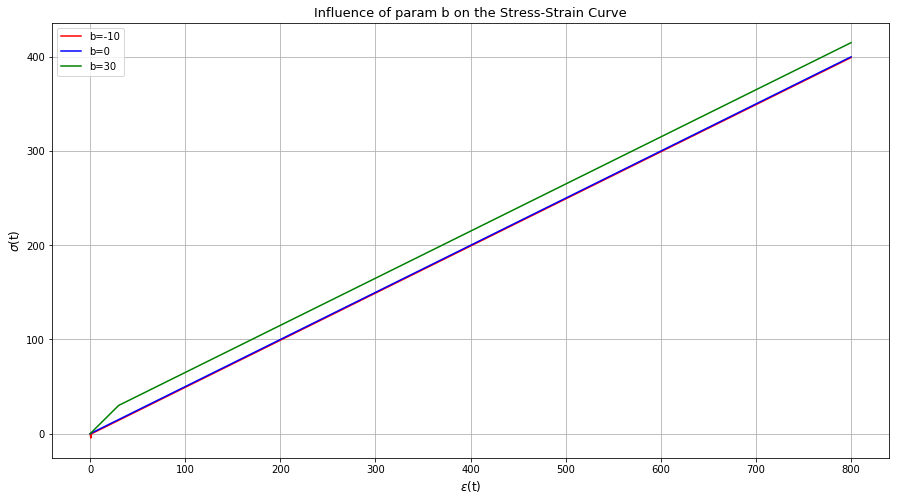

In [17]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(rmab_1.strain,rmab_1.stress,color='red',label='b=-10')
plt.plot(rmab_2.strain,rmab_2.stress,color='blue',label='b=0')
plt.plot(rmab_3.strain,rmab_3.stress,color='green',label='b=30')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\epsilon$(t)',size=12)
plt.ylabel(r'$\sigma$(t)',size=12)
plt.title('Influence of param b on the Stress-Strain Curve',size=13)
plt.show()

#### 4. Role of Parameter a

In [18]:
rmaa_1 = RMA(strain)
rmaa_1.activate(1,1,1,0.5)
rmaa_2 = RMA(strain)
rmaa_2.activate(1,1,1,1)
rmaa_3 = RMA(strain)
rmaa_3.activate(1,1,1,2)

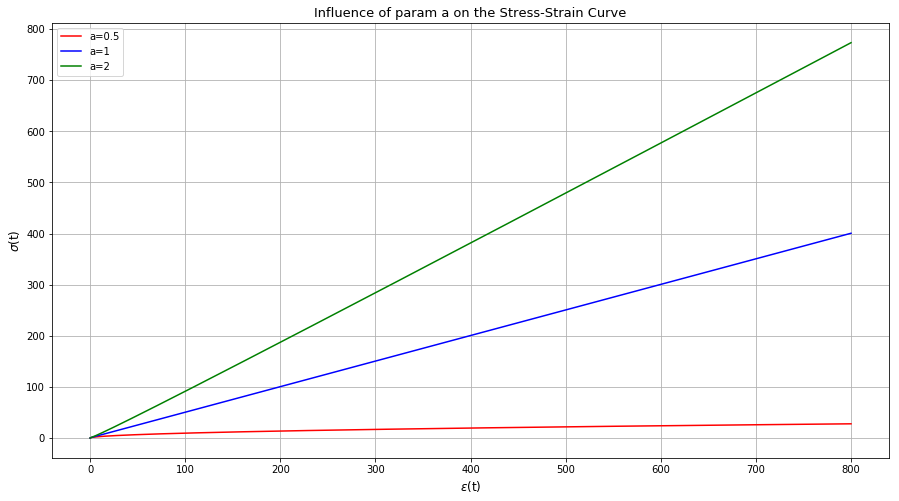

In [19]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(rmaa_1.strain,rmaa_1.stress,color='red',label='a=0.5')
plt.plot(rmaa_2.strain,rmaa_2.stress,color='blue',label='a=1')
plt.plot(rmaa_3.strain,rmaa_3.stress,color='green',label='a=2')
plt.legend()
plt.grid(True)
plt.xlabel(r'$\epsilon$(t)',size=12)
plt.ylabel(r'$\sigma$(t)',size=12)
plt.title('Influence of param a on the Stress-Strain Curve',size=13)
plt.show()

#### 5. Tests for fun

In [20]:
N         = 1000
disc_time = np.array(range(N+1))
slope     = 0.01
strain    = np.sin(slope * disc_time)

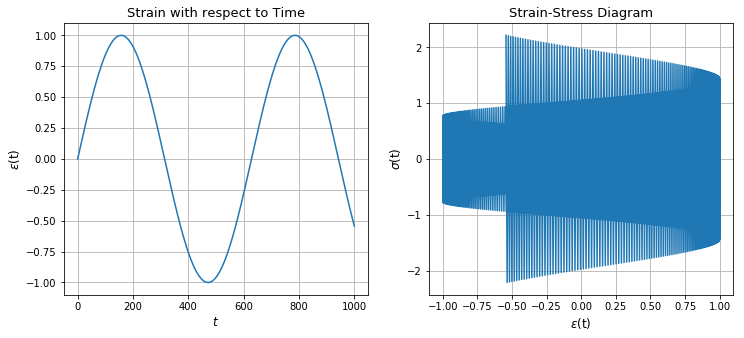

In [21]:
rma = RMA(strain)
rma.activate(1,-0.001,300,1)
rma.plot()

### IV. Strain between [-0.2,0.2]

**E** = 200000 MPa ; **b** = 0.001 ; **A** = 1000 MPa ; **a** = 0.2 ; Parameters characterizing Steel

In [99]:
def strain_build(N,bool_):
    stop_inc  = int(N/2)
    sig       = np.sign(float(bool_)-0.5)
    disc_time = np.array(range(N+1))
    slope1    = sig * (0.4/N)
    slope2    = - slope1
    bias      = slope1*disc_time[stop_inc]-slope2*disc_time[stop_inc]
    return np.concatenate([slope1*disc_time[0:stop_inc],bias+slope2*disc_time[stop_inc:]])

In [107]:
E = 200000
b = 0.001
A = 1000
a = 0.2

N = 300
strain1 = strain_build(N,True)
strain2 = strain_build(N,False)
strain3 = np.concatenate([strain1,strain2])

In [108]:
rma1=RMA_newton(strain1)
rma2=RMA_newton(strain2)
rma3=RMA_newton(strain3)

In [109]:
rma1.activate(E,A,b,a)
rma2.activate(E,A,b,a)
rma3.activate(E,A,b,a)

100%|██████████| 601/601 [00:00<00:00, 59609.74it/s]


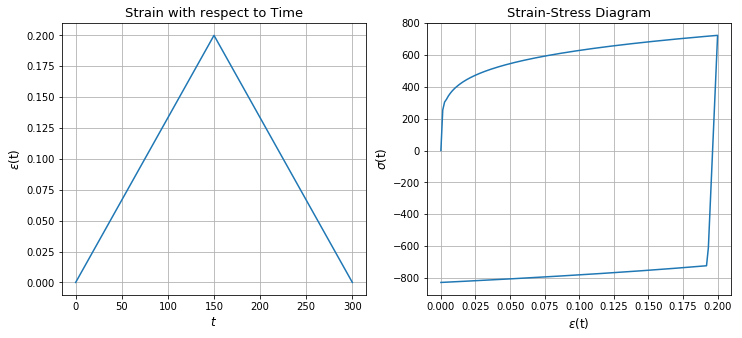

In [106]:
rma1.plot()

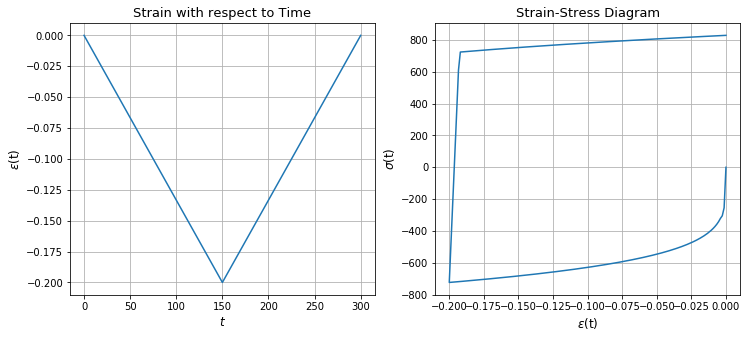

In [110]:
rma2.plot()

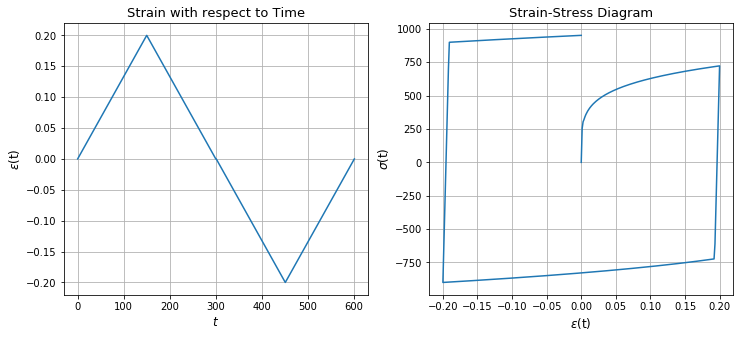

In [111]:
rma3.plot()